# Sentinel-2 Composite Generation

Generate a image composite with Google Earth Engine and Cloud Score+

In [1]:
import os
from typing import Literal

import cartopy.crs as ccrs
import contextily as cx
import ee
import geemap
import geopandas as gpd
import google.auth.transport.requests
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from dotenv import load_dotenv
from numpy.lib import recfunctions as rfn
from rasterio.io import MemoryFile

from deepfreezer.download import GEEDownloader
from deepfreezer.grid import MajorTOMGrid
from deepfreezer.utils import ROOT_DIR

In [2]:
# Load environment variables from .env file
load_dotenv()
GEE_PROJECT = os.environ.get("GEE_PROJECT")


creds = ee.data.get_persistent_credentials()
auth_req = google.auth.transport.requests.Request()
creds.refresh(auth_req)
ee.Initialize(
    project=GEE_PROJECT, opt_url="https://earthengine-highvolume.googleapis.com"
)

## Load grid

In [3]:
# Import SGI
sgi = gpd.read_file(ROOT_DIR / "data/raw/inventory_sgi2016_r2020/SGI_2016_glaciers.shp")

# Clean file
sgi = sgi.drop(columns="pk_glacier")
sgi.gid = sgi.gid.astype(int)
sgi = sgi.set_index("gid", verify_integrity=True).sort_index().to_crs("EPSG:4326")
sgi_bounds = sgi.total_bounds
# Get a single shape of the union
sgi_union = sgi.union_all()

In [4]:
grid = MajorTOMGrid(dist=10_000)
cells = grid.get_cells(aoi=sgi_union, buffer_ratio=0.1)
cells.head()


,lon_idx,lat_idx,lon,lat,lon_spacing,id,utm_zone,geometry
4390551,1451,1512,6.957767,45.808383,0.128848,u0huw74m,EPSG:32632,"POLYGON ((6.94488 45.7994, 7.0995 45.7994, 7.0..."
4390552,1452,1512,7.086614,45.808383,0.128848,u0jh970m,EPSG:32632,"POLYGON ((7.07373 45.7994, 7.22835 45.7994, 7...."
4390553,1453,1512,7.215462,45.808383,0.128848,u0jhs5nj,EPSG:32632,"POLYGON ((7.20258 45.7994, 7.35719 45.7994, 7...."
4390554,1454,1512,7.344309,45.808383,0.128848,u0jhx55v,EPSG:32632,"POLYGON ((7.33142 45.7994, 7.48604 45.7994, 7...."
4393342,1448,1513,6.905701,45.898204,0.129079,u0hvj5s8,EPSG:32632,"POLYGON ((6.89279 45.88922, 7.04769 45.88922, ..."


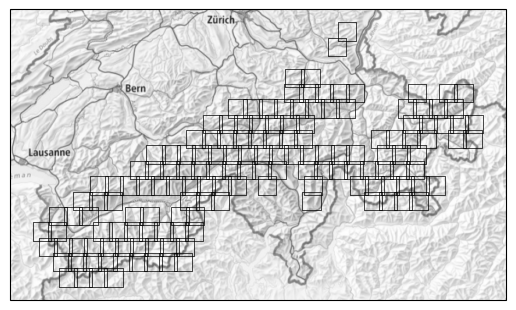

In [5]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={"projection": proj})
cells.plot(ax=ax, edgecolor="black", linewidth=0.5, color="None")

cx.add_basemap(
    ax,
    crs="epsg:4326",
    source=cx.providers.SwissFederalGeoportal.NationalMapGrey,
    attribution=False,
)


## Compute composite

In [6]:
BANDS = ["B4", "B3", "B2"]
QA_BAND = "cs_cdf"
CLEAR_THRESHOLD = 0.5

In [7]:
S2_TOA = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
S2_SR = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
S2_CSP = ee.ImageCollection("GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED")


def create_composite_cs(
    image_col: ee.ImageCollection,
    qa_band: Literal["cs", "cs_cdf"] = "cs_cdf",
    threshold: float = 0.6,
) -> ee.Image:
    """Create a Sentinel-2 composite in the desired ROI using the Google Cloud Score+"""

    return (
        image_col.linkCollection(S2_CSP, [qa_band])
        .map(lambda img: img.updateMask(img.select(qa_band).gte(threshold)))
        .median()
    )


In [8]:
test_cell = cells.iloc[0]
test_coords = (test_cell.lon, test_cell.lat)
test_crs = test_cell.utm_zone
test_id = test_cell.id

test_start, test_end = "2023-06-01", "2023-09-30"

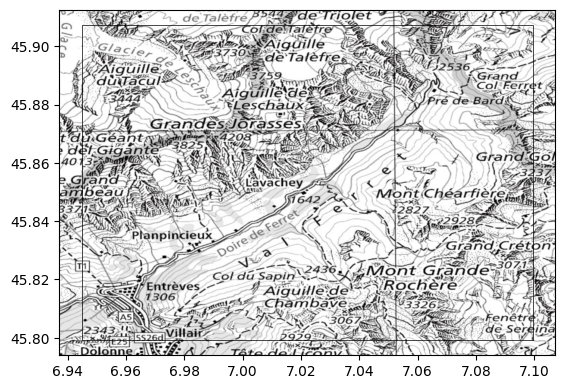

In [9]:
df_plot = gpd.GeoDataFrame([test_cell])

fig, ax = plt.subplots()

df_plot.plot(ax=ax, edgecolor="black", linewidth=0.5, color="None")

cx.add_basemap(
    ax,
    crs="epsg:4326",
    source=cx.providers.SwissFederalGeoportal.NationalMapGrey,
    attribution=False,
)


In [10]:
roi_coords = list(test_cell.geometry.exterior.coords)
roi_ee = ee.Geometry.Polygon(roi_coords)
point_ee = ee.Geometry.Point(test_cell.lon, test_cell.lat)

s2_filtered = S2_SR.filterDate(test_start, test_end).filterBounds(roi_ee).select(BANDS)
composite_cs = create_composite_cs(
    s2_filtered, qa_band=QA_BAND, threshold=CLEAR_THRESHOLD
)

visualization = {
    "min": 0,
    "max": 3000,
    "bands": ["B4", "B3", "B2"],
}

m = geemap.Map()
m.center_object(roi_ee, 12)
m.addLayer(composite_cs, visualization, "Cloud Score+")
m.addLayer(roi_ee, None, "Cell bounds (padded)")
m.addLayer(point_ee, {"color": "red"}, "Grid point")
m

Map(center=[45.85330207156129, 7.022190408015984], controls=(WidgetControl(options=['position', 'transparent_b…

## Download data with `computePixels`

In [11]:
def get_s2_composite(roi: ee.Geometry, start: str, end: str):
    """Get a two-month Sentinel-2 median composite in the ROI."""

    s2_filtered = S2_SR.filterBounds(roi).filterDate(start, end)
    return create_composite_cs(s2_filtered)


In [12]:
img = get_s2_composite(roi_ee, test_start, test_end).toInt16()

### Numpy example

In [33]:
write_dir = ROOT_DIR / "data/raw/ee/s2-l2a-10m"
dl = GEEDownloader(
    grid_dist=10_000,
    padding_ratio=0.1,
    scale=10,
    bands=["B4", "B3", "B2"],
    file_format="NPY",
    write_dir=write_dir,
)

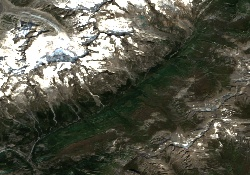

In [34]:
thumb = dl.load_thumb(test_cell, img)
thumb


In [35]:
# Write array
path = dl.write_patch(img, coords=test_coords, crs=test_crs, id_=test_id)


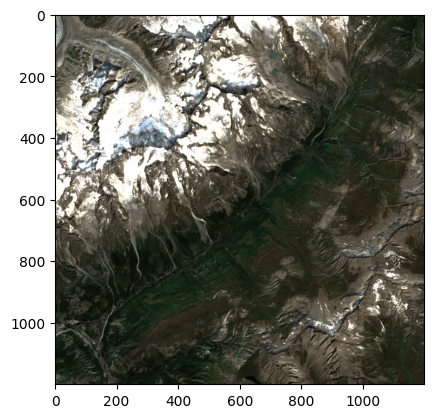

In [36]:
# Load array
array = np.load(path)

# Visualize array
a = rfn.structured_to_unstructured(array[["B4", "B3", "B2"]])
a = (a / (3 * a.std())).clip(0, 1)
plt.imshow(a);

### GeoTIFF example

In [ ]:
write_dir = ROOT_DIR / "data/raw/ee/s2-l2a-10m"
dl = GEEDownloader(
    file_format="GEO_TIFF",
    grid_dist=10_000,
    padding_ratio=0.1,
    scale=10,
    bands=["B4", "B3", "B2"],
    write_dir=write_dir,
)

path = dl.write_patch(img, coords=test_coords, crs=test_crs, id_=test_id)


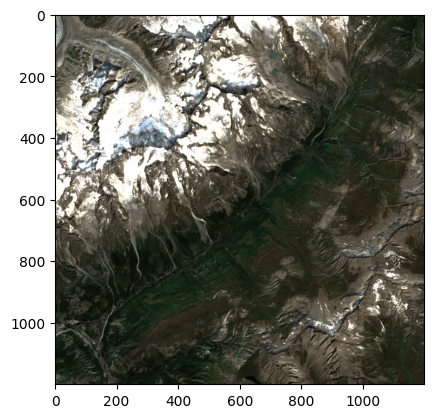

In [38]:
# Load array
with rasterio.open(path) as src:
    a = src.read()

a = a.transpose([1, 2, 0])
a = (a / (3 * a.std())).clip(0, 1)
plt.imshow(a)

### Batch downloading

In [17]:
test_cells = cells.sample(n=5, random_state=42)
test_cells

,lon_idx,lat_idx,lon,lat,lon_spacing,id,utm_zone,geometry
4410018,1456,1519,9.775525,46.437126,0.130340,u0qbnmw7,EPSG:32632,"POLYGON ((9.76249 46.42814, 9.9189 46.42814, 9..."
4412762,1438,1520,7.701233,46.526946,0.130529,u0m2xjzz,EPSG:32632,"POLYGON ((7.68818 46.51796, 7.84482 46.51796, ..."
4412773,1449,1520,9.137056,46.526946,0.130529,u0q2xvvr,EPSG:32632,"POLYGON ((9.124 46.51796, 9.28064 46.51796, 9...."
4415537,1455,1521,10.265165,46.616766,0.130766,u0r31w6f,EPSG:32632,"POLYGON ((10.25209 46.60778, 10.40901 46.60778..."
4398918,1450,1515,7.769784,46.077844,0.129496,u0jw0u1y,EPSG:32632,"POLYGON ((7.75683 46.06886, 7.91223 46.06886, ..."


In [54]:
test_points = gpd.GeoDataFrame(
    test_cells,
    geometry=gpd.points_from_xy(test_cells.lon, test_cells.lat),
    crs=test_cells.crs,
)

In [18]:
write_dir = ROOT_DIR / "data/raw/ee/s2-l2a-10m"
dl = GEEDownloader(
    file_format="GEO_TIFF",
    grid_dist=10_000,
    padding_ratio=0.1,
    scale=10,
    bands=["B4", "B3", "B2"],
    write_dir=write_dir,
)


In [28]:
minx, miny, maxx, maxy = test_cells.total_bounds
bounds_coords = [
    [minx, miny],
    [maxx, miny],
    [maxx, maxy],
    [minx, maxy],
    [minx, miny],  # close the polygon
]
roi_ee = ee.Geometry.Polygon([bounds_coords])
img = get_s2_composite(roi_ee, test_start, test_end).toInt16()

In [30]:
dl = GEEDownloader(
    file_format="GEO_TIFF",
    grid_dist=10_000,
    padding_ratio=0.1,
    scale=10,
    bands=["B4", "B3", "B2"],
    write_dir=write_dir,
)

test_tiffs = dl.write_patches_from_df(img, test_cells)

In [34]:
test_tiffs

[PosixPath('/Users/lgentn/Repositories/deep-glacier-inventory/data/raw/ee/s2-l2a-10m/patch-u0qbnmw7.tif'),
 PosixPath('/Users/lgentn/Repositories/deep-glacier-inventory/data/raw/ee/s2-l2a-10m/patch-u0m2xjzz.tif'),
 PosixPath('/Users/lgentn/Repositories/deep-glacier-inventory/data/raw/ee/s2-l2a-10m/patch-u0q2xvvr.tif'),
 PosixPath('/Users/lgentn/Repositories/deep-glacier-inventory/data/raw/ee/s2-l2a-10m/patch-u0r31w6f.tif'),
 PosixPath('/Users/lgentn/Repositories/deep-glacier-inventory/data/raw/ee/s2-l2a-10m/patch-u0jw0u1y.tif')]

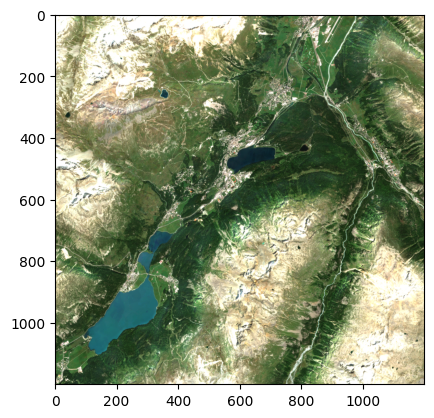

In [76]:
# Load array
with rasterio.open(str(test_tiffs[0])) as src:
    a = src.read()

a = a.transpose([1, 2, 0])
a = (a / (3 * a.std())).clip(0, 1)
plt.imshow(a)


In [77]:
# Plot the locally saved tiffs on a geemap map.
# Add additional layer with shapes of the grid cells, stored in a geopandas data frame

import geemap.foliumap as geemap

m = geemap.Map()

# Add each GeoTIFF as a layer
for path in test_tiffs:
    if path is not None:
        m.add_raster(
            str(path),
            # indexes=[1, 2, 3],
            # vmin=0,
            # vmax=5000,
            layer_name=f"Patch {path.stem}",
        )

# Add the grid cells as a vector layer
m.add_gdf(test_cells, layer_name="Grid Cells", style={"color": "red", "fillOpacity": 0})
# Add the grid points as a vector layer
m.add_gdf(
    test_points,
    layer_name="Grid Points",
    style={"color": "white"},
)
# Create a geemap map centered on the test cells
center = [test_cells.lat.mean(), test_cells.lon.mean()]
m.set_center(*center, zoom=8)

m
